In [8]:
import org.apache.spark.{SparkConf, SparkContext}
import org.apache.hadoop.fs._
import org.apache.spark.sql
import org.apache.spark.sql.types._
import org.apache.spark.sql.Encoders
import org.apache.spark.sql.functions.{expr,col,pow}
import org.apache.spark.sql.functions.udf
import org.apache.spark.sql.functions._
import org.apache.spark.sql.hive.HiveContext;

In [7]:
sc.stop()

In [9]:
val conf = new SparkConf().setAppName("Flight status")
val sc = new SparkContext(conf)
val spark = new SQLContext(sc) 
val hive = new org.apache.spark.sql.hive.HiveContext(sc)

conf = org.apache.spark.SparkConf@4387b512
sc = org.apache.spark.SparkContext@3d8536b9
spark = org.apache.spark.sql.SQLContext@7a3c51a
hive = org.apache.spark.sql.hive.HiveContext@60e1eec0


org.apache.spark.sql.hive.HiveContext@60e1eec0

# JSON which we have has multi lines so we will get error like _corrupt_record: string as spark will not understand the format 

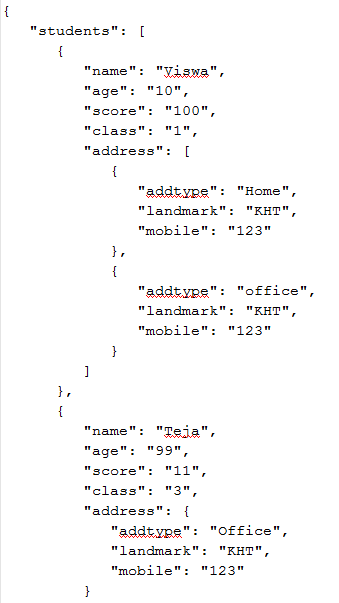

In [3]:
val people = spark.read.json("/user/viswatejaster9073/JSON/students.json")

people = [_corrupt_record: string]


[_corrupt_record: string]

## To overcome this issue we have two options

### Reading JSON as a whole text file using RDD and then convert it to JSON

In [4]:
val jrdd = sc.wholeTextFiles("/user/viswatejaster9073/JSON/students.json").values

jrdd = MapPartitionsRDD[6] at values at <console>:43


MapPartitionsRDD[6] at values at <console>:43

In [5]:
val jsonstudents = spark.read.json(jrdd)

jsonstudents = [students: array<struct<address:array<struct<addtype:string,landmark:string,mobile:string>>,age:string,class:string,name:string,score:string>>]


[students: array<struct<address:array<struct<addtype:string,landmark:string,mobile:string>>,age:string,class:string,name:string,score:string>>]

In [6]:
jsonstudents.printSchema

root
 |-- students: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- addtype: string (nullable = true)
 |    |    |    |    |-- landmark: string (nullable = true)
 |    |    |    |    |-- mobile: string (nullable = true)
 |    |    |-- age: string (nullable = true)
 |    |    |-- class: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- score: string (nullable = true)



In [7]:
jsonstudents.show()

+--------------------+
|            students|
+--------------------+
|[[[[Home, KHT, 12...|
+--------------------+



### Reading JSON with multiple lines as true

In [10]:
val std = spark.read.option("multiline", "true").json("/user/viswatejaster9073/JSON/students.json")

std = [students: array<struct<address:array<struct<addtype:string,landmark:string,mobile:string>>,age:string,class:string,name:string,score:string>>]


[students: array<struct<address:array<struct<addtype:string,landmark:string,mobile:string>>,age:string,class:string,name:string,score:string>>]

In [11]:
std.printSchema

root
 |-- students: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- addtype: string (nullable = true)
 |    |    |    |    |-- landmark: string (nullable = true)
 |    |    |    |    |-- mobile: string (nullable = true)
 |    |    |-- age: string (nullable = true)
 |    |    |-- class: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- score: string (nullable = true)



# Viewing JSON dataframe
## if you see the below results our Dataframe it read the whole json as a single line

In [5]:
std.show()

+--------------------+
|        OrderedItems|
+--------------------+
|[[[9878987890, 12...|
+--------------------+



### lets use spark SQL to seperate/explode the the single column called students 

In [11]:
std.createOrReplaceTempView("stu")

In [12]:
val result = spark.sql("select s.address.addtype,s.address.mobile,s.address.landmark,s.age,s.class,s.name,s.score from stu lateral view explode(students) t as s")

result = [addtype: array<string>, mobile: array<string> ... 5 more fields]


[addtype: array<string>, mobile: array<string> ... 5 more fields]

#### If you see the below result the addtype,Landmark and mobile is of type array, so it is difficult to process the data

In [13]:
result.show()
result.printSchema

+-------------+-----------+-----------+---+-----+-----+-----+
|      addtype|     mobile|   landmark|age|class| name|score|
+-------------+-----------+-----------+---+-----+-----+-----+
|[Home, Home1]|[123, 1231]|[KHT, KHT1]|V10|   V1|Viswa| V100|
|    [TOffice]|     [T123]|     [TKHT]| T9|   T3| Teja|  T11|
|    [AOffice]|     [A123]|     [AKHT]|A11|  A21|Ashok| A111|
+-------------+-----------+-----------+---+-----+-----+-----+

root
 |-- addtype: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- mobile: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- landmark: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- age: string (nullable = true)
 |-- class: string (nullable = true)
 |-- name: string (nullable = true)
 |-- score: string (nullable = true)



# Now explode the address 

## Lets create a sepereate dataframe for address and students 

### creating dataframe for address
#### I am creating a dataframe which has address and name

In [14]:
val add = spark.sql("select s.address,s.name from stu lateral view explode(students) t as s")
add.show()
add.printSchema

+--------------------+-----+
|             address| name|
+--------------------+-----+
|[[Home, KHT, 123]...|Viswa|
|[[TOffice, TKHT, ...| Teja|
|[[AOffice, AKHT, ...|Ashok|
+--------------------+-----+

root
 |-- address: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- addtype: string (nullable = true)
 |    |    |-- landmark: string (nullable = true)
 |    |    |-- mobile: string (nullable = true)
 |-- name: string (nullable = true)



add = [address: array<struct<addtype:string,landmark:string,mobile:string>>, name: string]


[address: array<struct<addtype:string,landmark:string,mobile:string>>, name: string]

#### If you see the above response for show() action the address fileds is array of array means nested array, so we have explode it to make it one dimention array as shown below

In [15]:
add.createOrReplaceTempView("add")

In [16]:
val add1 = spark.sql("select explode(address),name from add")
add1.show()

+--------------------+-----+
|                 col| name|
+--------------------+-----+
|    [Home, KHT, 123]|Viswa|
| [Home1, KHT1, 1231]|Viswa|
|[TOffice, TKHT, T...| Teja|
|[AOffice, AKHT, A...|Ashok|
+--------------------+-----+



add1 = [col: struct<addtype: string, landmark: string ... 1 more field>, name: string]


[col: struct<addtype: string, landmark: string ... 1 more field>, name: string]

In [17]:
add1.createOrReplaceTempView("add1")

In [18]:
val address = spark.sql("select col.addtype,col.landmark,col.mobile,name from add1")
address.show()

+-------+--------+------+-----+
|addtype|landmark|mobile| name|
+-------+--------+------+-----+
|   Home|     KHT|   123|Viswa|
|  Home1|    KHT1|  1231|Viswa|
|TOffice|    TKHT|  T123| Teja|
|AOffice|    AKHT|  A123|Ashok|
+-------+--------+------+-----+



address = [addtype: string, landmark: string ... 2 more fields]


[addtype: string, landmark: string ... 2 more fields]

## Creating dataframe for Student

In [19]:
val student = spark.sql("select s.name,s.score,s.class from stu lateral view explode(students) t as s")

student = [name: string, score: string ... 1 more field]


[name: string, score: string ... 1 more field]

In [20]:
address.show()
student.show()

+-------+--------+------+-----+
|addtype|landmark|mobile| name|
+-------+--------+------+-----+
|   Home|     KHT|   123|Viswa|
|  Home1|    KHT1|  1231|Viswa|
|TOffice|    TKHT|  T123| Teja|
|AOffice|    AKHT|  A123|Ashok|
+-------+--------+------+-----+

+-----+-----+-----+
| name|score|class|
+-----+-----+-----+
|Viswa| V100|   V1|
| Teja|  T11|   T3|
|Ashok| A111|  A21|
+-----+-----+-----+



# Now we need to join the two tables

In [21]:
val finaldf = student.join(address,student("name") === address("name"),"right")

finaldf = [name: string, score: string ... 5 more fields]


[name: string, score: string ... 5 more fields]

In [22]:
finaldf.printSchema

root
 |-- name: string (nullable = true)
 |-- score: string (nullable = true)
 |-- class: string (nullable = true)
 |-- addtype: string (nullable = true)
 |-- landmark: string (nullable = true)
 |-- mobile: string (nullable = true)
 |-- name: string (nullable = true)



In [23]:
finaldf.show()

+-----+-----+-----+-------+--------+------+-----+
| name|score|class|addtype|landmark|mobile| name|
+-----+-----+-----+-------+--------+------+-----+
|Viswa| V100|   V1|   Home|     KHT|   123|Viswa|
|Viswa| V100|   V1|  Home1|    KHT1|  1231|Viswa|
| Teja|  T11|   T3|TOffice|    TKHT|  T123| Teja|
|Ashok| A111|  A21|AOffice|    AKHT|  A123|Ashok|
+-----+-----+-----+-------+--------+------+-----+



# store the address and student in a HIVE database

In [24]:
student.write.mode("overwrite").saveAsTable("student_details");

In [25]:
address.write.mode("overwrite").saveAsTable("address_details")